# Analise de configuração da rede MLP com a base Mammography

Leitura da base de dados

In [1]:
import pandas as pd

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler

from extensions import *
from IPython.display import display
from plot_util import *
from train_util import *

NOTEBOOK = True

print('read database')
db_file = 'database.csv'
db_frame = pd.read_csv(db_file, header=None)
print(f'instances: {db_frame.shape[0]}')
print()

read database
instances: 11183



Separação de instâncias positivas e negativas

In [2]:
print('split negatives and positives')
negs_frame = db_frame[db_frame.iloc[:, -1] == 0]
poss_frame = db_frame[db_frame.iloc[:, -1] == 1]
print('shuffle negatives and positives')
negs_frame = negs_frame.sample(frac=1).reset_index(drop=True)
poss_frame = poss_frame.sample(frac=1).reset_index(drop=True)
print(f'neg: {negs_frame.shape[0]}, pos: {poss_frame.shape[0]}')
print()

split negatives and positives
shuffle negatives and positives
neg: 10923, pos: 260



Divisão das instâncias usando k-fold cross validation com 10 folds

In [3]:
k = 10
print(f'create k={k} folds')
negs_frame_folds = np.array_split(negs_frame, k)
poss_frame_folds = np.array_split(poss_frame, k)
print('merge and shuffle individual folds')
frame_folds = [pd.concat([negs_frame_folds[i], poss_frame_folds[i]], axis=0, join='outer') for i in range(k)]
frame_folds = [ff.sample(frac=1).reset_index(drop=True) for ff in frame_folds]
print(f'split instances and classes and transform in numpy arrays')
base_folds = [(ff.iloc[:, :-1].as_matrix(), ff.iloc[:, -1].as_matrix()) for ff in frame_folds]
print('\n'.join(f'{i}: n={negs_frame_folds[i].shape[0]} p={poss_frame_folds[i].shape[0]} t={frame_folds[i].shape[0]}'
                for i in range(k)))
print()

create k=10 folds
merge and shuffle individual folds
split instances and classes and transform in numpy arrays
0: n=1093 p=26 t=1119
1: n=1093 p=26 t=1119
2: n=1093 p=26 t=1119
3: n=1092 p=26 t=1118
4: n=1092 p=26 t=1118
5: n=1092 p=26 t=1118
6: n=1092 p=26 t=1118
7: n=1092 p=26 t=1118
8: n=1092 p=26 t=1118
9: n=1092 p=26 t=1118



Resample da amostra usando algoritmos de under sampling e over sampling, os algoritmos usados foram
RandomOverSampler, SMOTE, ClusterCentroids (K-Means) e RandomUnderSampler

Os algoritmos são aplicados individualmente em cada fold para que não haja sobreposição dos dados em diferentes folds

In [4]:
print('resample folds')
samplers = {
    'r-over': RandomOverSampler(), 'smote': SMOTE(),
    'k-means': ClusterCentroids(), 'r-under': RandomUnderSampler()
}
samples_folds = {name: [sampler.fit_sample(*fold) for fold in base_folds] for name, sampler in samplers.items()}
for name, sample_folds in samples_folds.items():
    print('sampler %s folds: %s' % (name, [len(fold[0]) for fold in sample_folds]))
print()

resample folds
sampler r-over folds: [2186, 2186, 2186, 2184, 2184, 2184, 2184, 2184, 2184, 2184]
sampler smote folds: [2186, 2186, 2186, 2184, 2184, 2184, 2184, 2184, 2184, 2184]
sampler k-means folds: [52, 52, 52, 52, 52, 52, 52, 52, 52, 52]
sampler r-under folds: [52, 52, 52, 52, 52, 52, 52, 52, 52, 52]



Configurações base, a partir destas, cada atributo será testado independentemente

In [5]:
model_class = ModMLPClassifier

base_configurations = [
    {
        'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,),
        'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200,

        'train_folds': k - 1,  # number of training folds (the last will be choose to validate)
        'max_fail': 3  # max number of consecutive fails in validation score reduction
    },
    {
        'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,),
        'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800,

        'train_folds': k - 1,  # number of training folds (the last will be choose to validate)
        'max_fail': 3  # max number of consecutive fails in validation score reduction
    },
    {
        'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,),
        'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200,

        'train_folds': k - 1,  # number of training folds (the last will be choose to validate)
        'max_fail': 3  # max number of consecutive fails in validation score reduction
    }
]
print('base configurations:')
if NOTEBOOK:
    display(pd.DataFrame(base_configurations))
else:
    print(pd.DataFrame(base_configurations).to_string())

base configurations:


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds
0,logistic,True,"(8,)",invscaling,0.0100,3,200,sgd,9
1,logistic,True,"(16,)",adaptive,0.0010,3,800,sgd,9
2,logistic,True,"(32,)",constant,0.0001,3,3200,sgd,9


Atributos principais a seram variados e seus valores

In [6]:
variations = [
    ('learning_rate_init', [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]),
    ('hidden_layer_sizes', [(2 ** x,) for x in range(1, 8)]),
    ('max_iter', [200, 400, 800, 1600, 3200, 6400]),
    ('learning_rate', ['constant', 'invscaling', 'adaptive'])
]

if NOTEBOOK:
    display(pd.DataFrame(variations))
else:
    print(pd.DataFrame(variations).to_string())

,0,1
0,learning_rate_init,"[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]"
1,hidden_layer_sizes,"[(2,), (4,), (8,), (16,), (32,), (64,), (128,)]"
2,max_iter,"[200, 400, 800, 1600, 3200, 6400]"
3,learning_rate,"[constant, invscaling, adaptive]"


Testes individuais com as diferentes bases geradas com os algoritmos de sampling
* K-Means

optimize model configuration for r-over with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
17,logistic,True,"(32,)",constant,0.0500,3,3200,sgd,9,0.901816,0.098184,0.895796
10,logistic,True,"(16,)",adaptive,0.0100,3,800,sgd,9,0.883568,0.116432,0.891045
11,logistic,True,"(16,)",adaptive,0.0500,3,800,sgd,9,0.854330,0.145670,0.889144
16,logistic,True,"(32,)",constant,0.0100,3,3200,sgd,9,0.903778,0.096222,0.797609
9,logistic,True,"(16,)",adaptive,0.0050,3,800,sgd,9,0.662062,0.337938,0.789379
5,logistic,True,"(8,)",invscaling,0.0500,3,200,sgd,9,0.546686,0.453314,0.673141
2,logistic,True,"(8,)",invscaling,0.0010,3,200,sgd,9,0.417616,0.582384,0.615702
12,logistic,True,"(32,)",constant,0.0001,3,3200,sgd,9,0.640612,0.359388,0.584175
8,logistic,True,"(16,)",adaptive,0.0010,3,800,sgd,9,0.518843,0.481157,0.567792
15,logistic,True,"(32,)",constant,0.0050,3,3200,sgd,9,0.598395,0.401605,0.540056


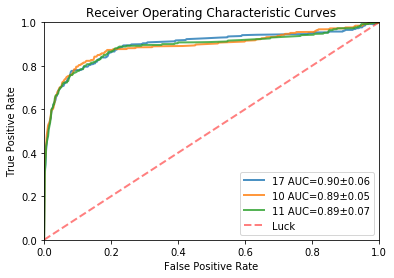


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
4,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.904592,0.095408,0.904295
17,logistic,True,"(16,)",adaptive,0.05,3,800,sgd,9,0.868468,0.131532,0.902592
20,logistic,True,"(128,)",adaptive,0.05,3,800,sgd,9,0.902255,0.097745,0.898996
19,logistic,True,"(64,)",adaptive,0.05,3,800,sgd,9,0.895912,0.104088,0.898206
6,logistic,True,"(128,)",constant,0.05,3,3200,sgd,9,0.905664,0.094336,0.897732
2,logistic,True,"(8,)",constant,0.05,3,3200,sgd,9,0.860682,0.139318,0.895985
18,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.884731,0.115269,0.895953
3,logistic,True,"(16,)",constant,0.05,3,3200,sgd,9,0.886783,0.113217,0.895058
13,logistic,True,"(128,)",adaptive,0.01,3,800,sgd,9,0.888568,0.111432,0.891935
12,logistic,True,"(64,)",adaptive,0.01,3,800,sgd,9,0.859857,0.140143,0.886150


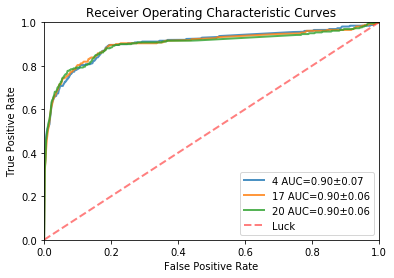


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
5,logistic,True,"(32,)",constant,0.05,3,6400,sgd,9,0.905752,0.094248,0.902297
11,logistic,True,"(16,)",adaptive,0.05,3,6400,sgd,9,0.906461,0.093539,0.902232
10,logistic,True,"(16,)",adaptive,0.05,3,3200,sgd,9,0.910306,0.089694,0.900303
7,logistic,True,"(16,)",adaptive,0.05,3,400,sgd,9,0.880889,0.119111,0.899853
16,logistic,True,"(128,)",adaptive,0.05,3,3200,sgd,9,0.888220,0.111780,0.899432
14,logistic,True,"(128,)",adaptive,0.05,3,800,sgd,9,0.891082,0.108918,0.899342
4,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.896436,0.103564,0.898956
17,logistic,True,"(128,)",adaptive,0.05,3,6400,sgd,9,0.884822,0.115178,0.898732
3,logistic,True,"(32,)",constant,0.05,3,1600,sgd,9,0.903866,0.096134,0.898697
13,logistic,True,"(128,)",adaptive,0.05,3,400,sgd,9,0.887775,0.112225,0.898655


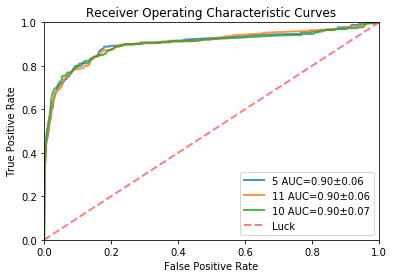


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 6400, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 6400, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
8,logistic,True,"(16,)",adaptive,0.05,3,3200,sgd,9,0.871850,0.128150,0.902106
0,logistic,True,"(32,)",constant,0.05,3,6400,sgd,9,0.906015,0.093985,0.899109
5,logistic,True,"(16,)",adaptive,0.05,3,6400,sgd,9,0.878739,0.121261,0.896388
2,logistic,True,"(32,)",adaptive,0.05,3,6400,sgd,9,0.876053,0.123947,0.893457
6,logistic,True,"(16,)",constant,0.05,3,3200,sgd,9,0.890367,0.109633,0.887330
3,logistic,True,"(16,)",constant,0.05,3,6400,sgd,9,0.870622,0.129378,0.868896
4,logistic,True,"(16,)",invscaling,0.05,3,6400,sgd,9,0.657817,0.342183,0.823169
7,logistic,True,"(16,)",invscaling,0.05,3,3200,sgd,9,0.535615,0.464385,0.729877
1,logistic,True,"(32,)",invscaling,0.05,3,6400,sgd,9,0.682838,0.317162,0.699450


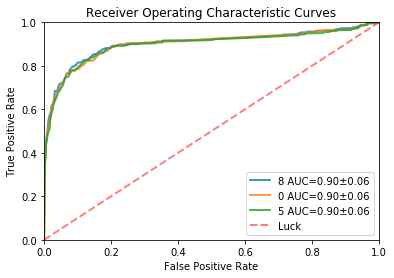


best configuration


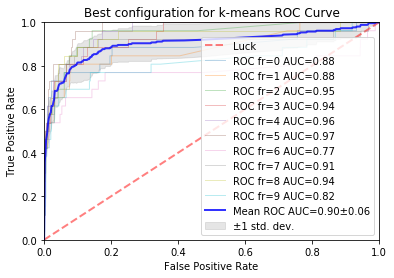

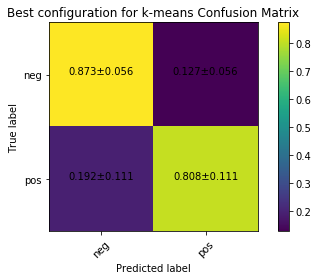

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


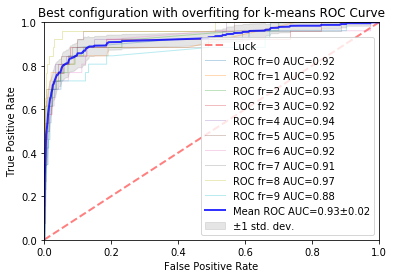

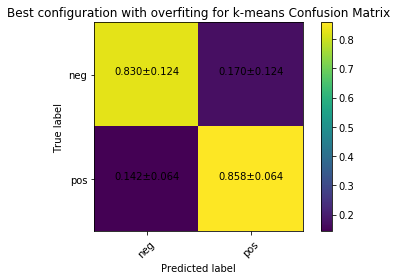




optimize model configuration for smote with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
16,logistic,True,"(32,)",constant,0.0100,3,3200,sgd,9,0.881619,0.118381,0.911294
11,logistic,True,"(16,)",adaptive,0.0500,3,800,sgd,9,0.871135,0.128865,0.899218
17,logistic,True,"(32,)",constant,0.0500,3,3200,sgd,9,0.867200,0.132800,0.893593
10,logistic,True,"(16,)",adaptive,0.0100,3,800,sgd,9,0.732001,0.267999,0.859041
9,logistic,True,"(16,)",adaptive,0.0050,3,800,sgd,9,0.710005,0.289995,0.812061
2,logistic,True,"(8,)",invscaling,0.0010,3,200,sgd,9,0.584886,0.415114,0.714979
8,logistic,True,"(16,)",adaptive,0.0010,3,800,sgd,9,0.673922,0.326078,0.704362
5,logistic,True,"(8,)",invscaling,0.0500,3,200,sgd,9,0.559655,0.440345,0.686940
3,logistic,True,"(8,)",invscaling,0.0050,3,200,sgd,9,0.395705,0.604295,0.603037
7,logistic,True,"(16,)",adaptive,0.0005,3,800,sgd,9,0.566548,0.433452,0.583439


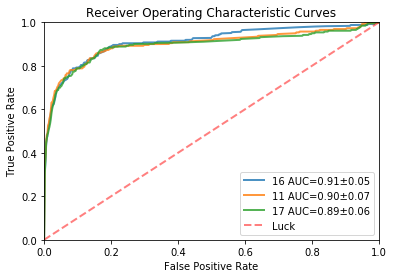


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
17,logistic,True,"(16,)",constant,0.05,3,3200,sgd,9,0.871241,0.128759,0.907843
12,logistic,True,"(64,)",adaptive,0.05,3,800,sgd,9,0.922565,0.077435,0.904365
13,logistic,True,"(128,)",adaptive,0.05,3,800,sgd,9,0.883654,0.116346,0.898974
18,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.889025,0.110975,0.896232
10,logistic,True,"(16,)",adaptive,0.05,3,800,sgd,9,0.890091,0.109909,0.895876
11,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.893221,0.106779,0.895285
19,logistic,True,"(64,)",constant,0.05,3,3200,sgd,9,0.885884,0.114116,0.895133
5,logistic,True,"(64,)",constant,0.01,3,3200,sgd,9,0.881877,0.118123,0.894417
20,logistic,True,"(128,)",constant,0.05,3,3200,sgd,9,0.900744,0.099256,0.890804
9,logistic,True,"(8,)",adaptive,0.05,3,800,sgd,9,0.866406,0.133594,0.887959


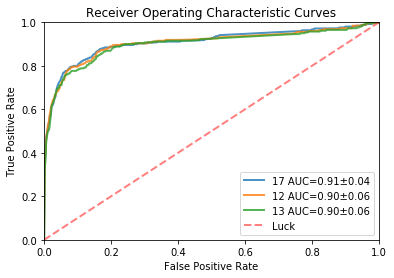


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
4,logistic,True,"(16,)",constant,0.05,3,3200,sgd,9,0.885530,0.114470,0.904855
10,logistic,True,"(64,)",adaptive,0.05,3,3200,sgd,9,0.886779,0.113221,0.901924
11,logistic,True,"(64,)",adaptive,0.05,3,6400,sgd,9,0.890721,0.109279,0.901802
2,logistic,True,"(16,)",constant,0.05,3,800,sgd,9,0.905654,0.094346,0.901112
8,logistic,True,"(64,)",adaptive,0.05,3,800,sgd,9,0.904675,0.095325,0.899930
0,logistic,True,"(16,)",constant,0.05,3,200,sgd,9,0.898414,0.101586,0.899743
13,logistic,True,"(128,)",adaptive,0.05,3,400,sgd,9,0.891707,0.108293,0.898338
17,logistic,True,"(128,)",adaptive,0.05,3,6400,sgd,9,0.880708,0.119292,0.898274
12,logistic,True,"(128,)",adaptive,0.05,3,200,sgd,9,0.895365,0.104635,0.897845
16,logistic,True,"(128,)",adaptive,0.05,3,3200,sgd,9,0.874899,0.125101,0.897510


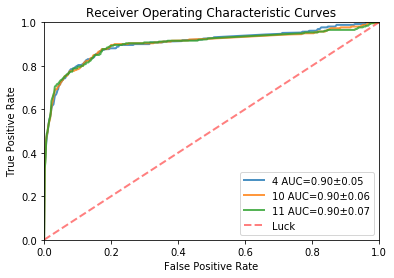


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 6400, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
3,logistic,True,"(64,)",constant,0.05,3,3200,sgd,9,0.884031,0.115969,0.905546
8,logistic,True,"(64,)",adaptive,0.05,3,6400,sgd,9,0.873641,0.126359,0.903898
5,logistic,True,"(64,)",adaptive,0.05,3,3200,sgd,9,0.894022,0.105978,0.898810
2,logistic,True,"(16,)",adaptive,0.05,3,3200,sgd,9,0.836287,0.163713,0.898048
6,logistic,True,"(64,)",constant,0.05,3,6400,sgd,9,0.875069,0.124931,0.896926
0,logistic,True,"(16,)",constant,0.05,3,3200,sgd,9,0.871674,0.128326,0.892974
7,logistic,True,"(64,)",invscaling,0.05,3,6400,sgd,9,0.598206,0.401794,0.844652
1,logistic,True,"(16,)",invscaling,0.05,3,3200,sgd,9,0.621649,0.378351,0.733889
4,logistic,True,"(64,)",invscaling,0.05,3,3200,sgd,9,0.848213,0.151787,0.706403


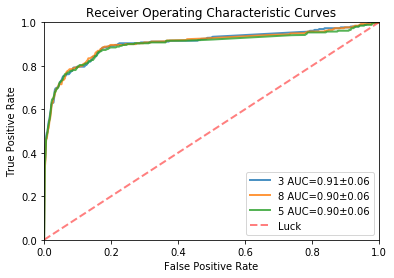


best configuration


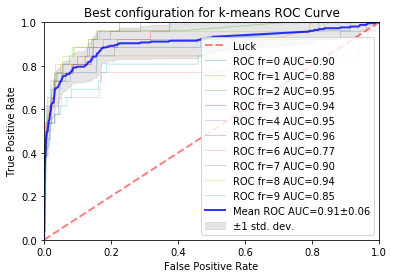

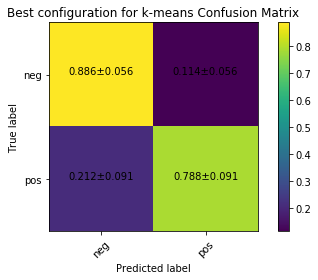

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


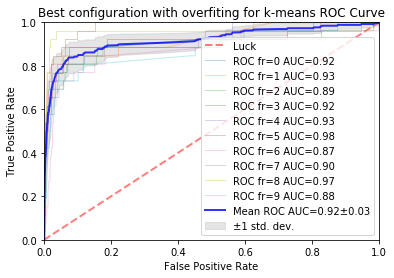

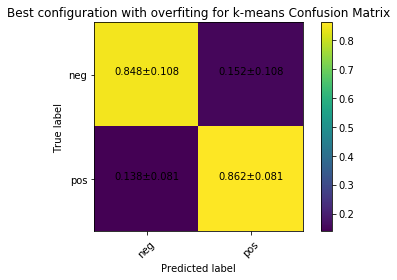




optimize model configuration for k-means with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
11,logistic,True,"(16,)",adaptive,0.0500,3,800,sgd,9,0.882133,0.117867,0.903947
17,logistic,True,"(32,)",constant,0.0500,3,3200,sgd,9,0.905564,0.094436,0.894440
10,logistic,True,"(16,)",adaptive,0.0100,3,800,sgd,9,0.846275,0.153725,0.855679
16,logistic,True,"(32,)",constant,0.0100,3,3200,sgd,9,0.897339,0.102661,0.831527
9,logistic,True,"(16,)",adaptive,0.0050,3,800,sgd,9,0.605018,0.394982,0.774093
5,logistic,True,"(8,)",invscaling,0.0500,3,200,sgd,9,0.680667,0.319333,0.659642
6,logistic,True,"(16,)",adaptive,0.0001,3,800,sgd,9,0.498124,0.501876,0.615536
15,logistic,True,"(32,)",constant,0.0050,3,3200,sgd,9,0.775243,0.224757,0.611245
7,logistic,True,"(16,)",adaptive,0.0005,3,800,sgd,9,0.311089,0.688911,0.571481
3,logistic,True,"(8,)",invscaling,0.0050,3,200,sgd,9,0.500271,0.499729,0.511318


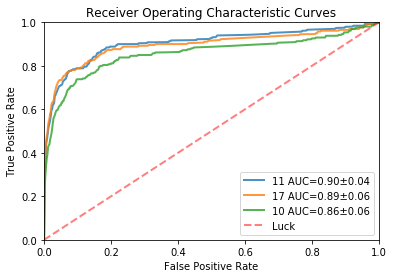


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
19,logistic,True,"(64,)",adaptive,0.01,3,800,sgd,9,0.897784,0.102216,0.906372
11,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.892783,0.107217,0.904985
1,logistic,True,"(4,)",adaptive,0.05,3,800,sgd,9,0.833747,0.166253,0.900481
12,logistic,True,"(64,)",constant,0.05,3,3200,sgd,9,0.912279,0.087721,0.898831
9,logistic,True,"(8,)",constant,0.05,3,3200,sgd,9,0.864613,0.135387,0.898774
5,logistic,True,"(64,)",adaptive,0.05,3,800,sgd,9,0.906725,0.093275,0.898708
3,logistic,True,"(16,)",adaptive,0.05,3,800,sgd,9,0.893943,0.106057,0.898120
6,logistic,True,"(128,)",adaptive,0.05,3,800,sgd,9,0.912724,0.087276,0.897957
18,logistic,True,"(32,)",adaptive,0.01,3,800,sgd,9,0.884913,0.115087,0.897804
13,logistic,True,"(128,)",constant,0.05,3,3200,sgd,9,0.920772,0.079228,0.897112


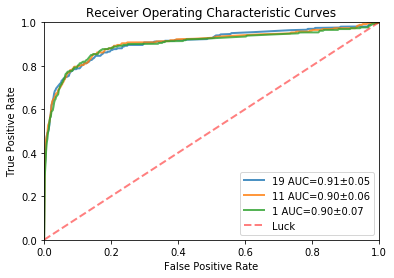


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
7,logistic,True,"(32,)",constant,0.05,3,400,sgd,9,0.883836,0.116164,0.905498
10,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.852639,0.147361,0.901176
8,logistic,True,"(32,)",constant,0.05,3,800,sgd,9,0.906558,0.093442,0.900430
9,logistic,True,"(32,)",constant,0.05,3,1600,sgd,9,0.898326,0.101674,0.896802
0,logistic,True,"(64,)",adaptive,0.01,3,200,sgd,9,0.882588,0.117412,0.895282
6,logistic,True,"(32,)",constant,0.05,3,200,sgd,9,0.866925,0.133075,0.894821
5,logistic,True,"(64,)",adaptive,0.01,3,6400,sgd,9,0.869338,0.130662,0.894691
13,logistic,True,"(4,)",adaptive,0.05,3,400,sgd,9,0.879005,0.120995,0.893791
16,logistic,True,"(4,)",adaptive,0.05,3,3200,sgd,9,0.833689,0.166311,0.893764
12,logistic,True,"(4,)",adaptive,0.05,3,200,sgd,9,0.863902,0.136098,0.893106


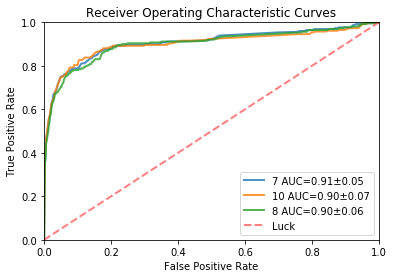


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
6,logistic,True,"(32,)",constant,0.05,3,800,sgd,9,0.908422,0.091578,0.899496
2,logistic,True,"(32,)",adaptive,0.05,3,400,sgd,9,0.893939,0.106061,0.898852
5,logistic,True,"(32,)",adaptive,0.05,3,3200,sgd,9,0.891891,0.108109,0.898011
3,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.894924,0.105076,0.897130
0,logistic,True,"(32,)",constant,0.05,3,400,sgd,9,0.888662,0.111338,0.895220
8,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.898053,0.101947,0.892757
7,logistic,True,"(32,)",invscaling,0.05,3,800,sgd,9,0.754283,0.245717,0.826358
1,logistic,True,"(32,)",invscaling,0.05,3,400,sgd,9,0.695437,0.304563,0.761129
4,logistic,True,"(32,)",invscaling,0.05,3,3200,sgd,9,0.621430,0.378570,0.750827


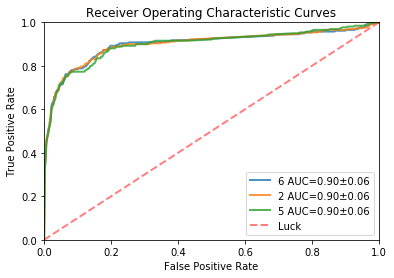


best configuration


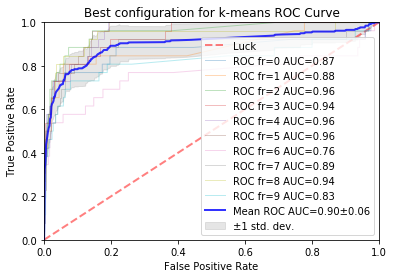

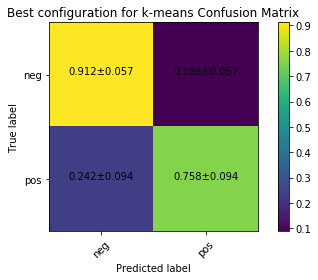

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


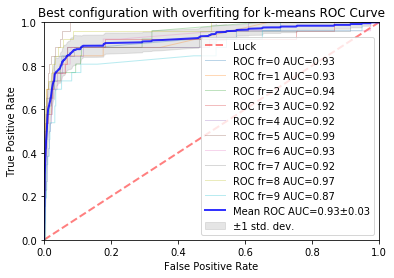

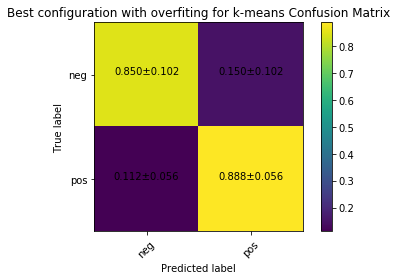




optimize model configuration for r-under with configuration range of 3
variation 0 -> learning_rate_init
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
17,logistic,True,"(32,)",constant,0.0500,3,3200,sgd,9,0.897882,0.102118,0.890849
11,logistic,True,"(16,)",adaptive,0.0500,3,800,sgd,9,0.877131,0.122869,0.890156
16,logistic,True,"(32,)",constant,0.0100,3,3200,sgd,9,0.862488,0.137512,0.863756
10,logistic,True,"(16,)",adaptive,0.0100,3,800,sgd,9,0.906386,0.093614,0.863417
5,logistic,True,"(8,)",invscaling,0.0500,3,200,sgd,9,0.741241,0.258759,0.841783
15,logistic,True,"(32,)",constant,0.0050,3,3200,sgd,9,0.625595,0.374405,0.683501
9,logistic,True,"(16,)",adaptive,0.0050,3,800,sgd,9,0.554384,0.445616,0.644878
6,logistic,True,"(16,)",adaptive,0.0001,3,800,sgd,9,0.608052,0.391948,0.621236
0,logistic,True,"(8,)",invscaling,0.0001,3,200,sgd,9,0.595530,0.404470,0.599786
14,logistic,True,"(32,)",constant,0.0010,3,3200,sgd,9,0.434531,0.565469,0.598405


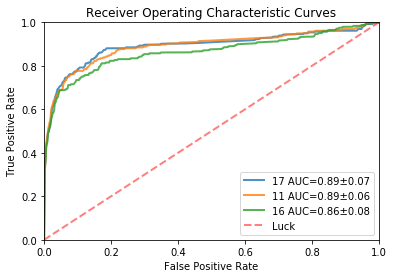


variation 1 -> hidden_layer_sizes
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
12,logistic,True,"(64,)",adaptive,0.05,3,800,sgd,9,0.906104,0.093896,0.900498
11,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.883834,0.116166,0.900365
2,logistic,True,"(8,)",constant,0.05,3,3200,sgd,9,0.850116,0.149884,0.899750
10,logistic,True,"(16,)",adaptive,0.05,3,800,sgd,9,0.872300,0.127700,0.899584
13,logistic,True,"(128,)",adaptive,0.05,3,800,sgd,9,0.887230,0.112770,0.899038
5,logistic,True,"(64,)",constant,0.05,3,3200,sgd,9,0.894921,0.105079,0.898475
9,logistic,True,"(8,)",adaptive,0.05,3,800,sgd,9,0.871580,0.128420,0.898184
4,logistic,True,"(32,)",constant,0.05,3,3200,sgd,9,0.858435,0.141565,0.897928
6,logistic,True,"(128,)",constant,0.05,3,3200,sgd,9,0.881243,0.118757,0.895609
8,logistic,True,"(4,)",adaptive,0.05,3,800,sgd,9,0.872755,0.127245,0.892905


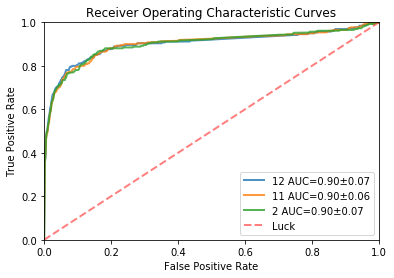


variation 2 -> max_iter
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
13,logistic,True,"(8,)",constant,0.05,3,400,sgd,9,0.861658,0.138342,0.903495
2,logistic,True,"(64,)",adaptive,0.05,3,800,sgd,9,0.883743,0.116257,0.901951
16,logistic,True,"(8,)",constant,0.05,3,3200,sgd,9,0.880344,0.119656,0.901078
12,logistic,True,"(8,)",constant,0.05,3,200,sgd,9,0.870327,0.129673,0.900262
6,logistic,True,"(32,)",adaptive,0.05,3,200,sgd,9,0.866036,0.133964,0.899488
11,logistic,True,"(32,)",adaptive,0.05,3,6400,sgd,9,0.907443,0.092557,0.899236
4,logistic,True,"(64,)",adaptive,0.05,3,3200,sgd,9,0.909681,0.090319,0.897915
8,logistic,True,"(32,)",adaptive,0.05,3,800,sgd,9,0.911917,0.088083,0.897882
10,logistic,True,"(32,)",adaptive,0.05,3,3200,sgd,9,0.885181,0.114819,0.897796
1,logistic,True,"(64,)",adaptive,0.05,3,400,sgd,9,0.859329,0.140671,0.897749


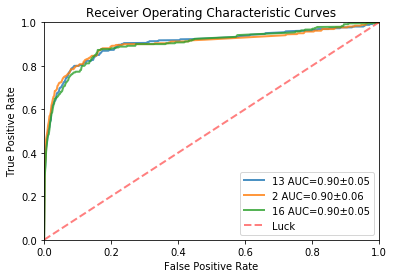


variation 3 -> learning_rate
configuration 1 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 400, 'train_folds': 9, 'max_fail': 3}
configuration 2 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.05, 'learning_rate': 'adaptive', 'max_iter': 800, 'train_folds': 9, 'max_fail': 3}
configuration 3 of 3
-> {'solver': 'sgd', 'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.05, 'learning_rate': 'constant', 'max_iter': 3200, 'train_folds': 9, 'max_fail': 3}


,activation,early_stopping,hidden_layer_sizes,learning_rate,learning_rate_init,max_fail,max_iter,solver,train_folds,mean score,mean mse,mean roc auc
8,logistic,True,"(8,)",adaptive,0.05,3,3200,sgd,9,0.849580,0.150420,0.901539
5,logistic,True,"(64,)",adaptive,0.05,3,800,sgd,9,0.896901,0.103099,0.897915
3,logistic,True,"(64,)",constant,0.05,3,800,sgd,9,0.903507,0.096493,0.894753
4,logistic,True,"(64,)",invscaling,0.05,3,800,sgd,9,0.288722,0.711278,0.887360
2,logistic,True,"(8,)",adaptive,0.05,3,400,sgd,9,0.874188,0.125812,0.886666
6,logistic,True,"(8,)",constant,0.05,3,3200,sgd,9,0.747157,0.252843,0.866181
0,logistic,True,"(8,)",constant,0.05,3,400,sgd,9,0.884561,0.115439,0.802807
1,logistic,True,"(8,)",invscaling,0.05,3,400,sgd,9,0.539249,0.460751,0.775769
7,logistic,True,"(8,)",invscaling,0.05,3,3200,sgd,9,0.725942,0.274058,0.586969


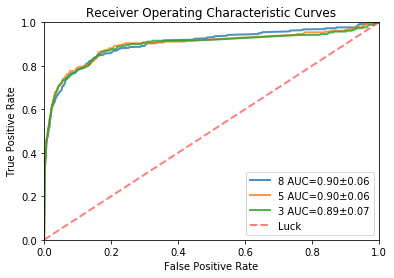


best configuration


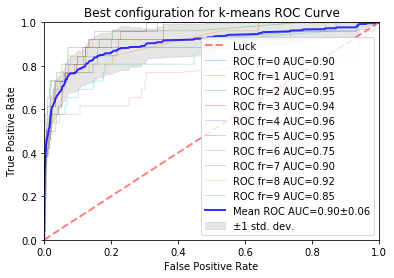

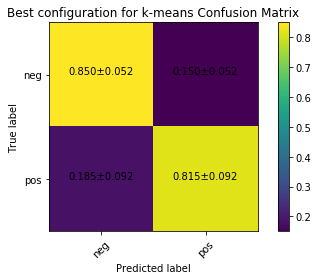

testing overfiting (increased verbose)
run 1 of 1, fold 1 of 10
run 1 of 1, fold 2 of 10
run 1 of 1, fold 3 of 10
run 1 of 1, fold 4 of 10
run 1 of 1, fold 5 of 10
run 1 of 1, fold 6 of 10
run 1 of 1, fold 7 of 10
run 1 of 1, fold 8 of 10
run 1 of 1, fold 9 of 10
run 1 of 1, fold 10 of 10


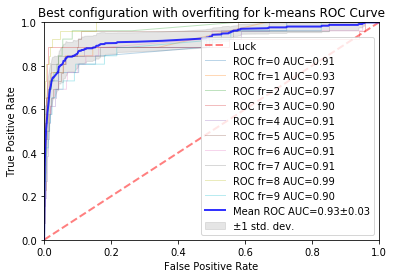

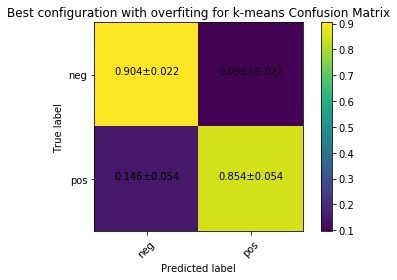

In [7]:
configuration_range = 3

for sample_method, sample_folds in samples_folds.items():
    print(f'optimize model configuration for {sample_method} with configuration range of {configuration_range}')
    configurations = base_configurations
    results = None
    for i, (variation_name, variation_values) in enumerate(variations):
        print(f'variation {i} -> {variation_name}')
        configurations_results = validate_model_configurations_variations(model_class, configurations,
                                                                          variation_name, variation_values,
                                                                          samples_folds['k-means'], base_folds,
                                                                          verbose=1)

        db_frame = pd.DataFrame([configuration for configuration, result in configurations_results])
        db_frame['mean score'] = [np.mean(result['score']) for _, result in configurations_results]
        db_frame['mean mse'] = [np.mean(result['mse']) for _, result in configurations_results]
        db_frame['mean roc auc'] = [np.mean(result['roc']['auc']) for _, result in configurations_results]
        db_frame['data'] = [(c, r) for c, r in configurations_results]
        db_frame.drop_duplicates([column for column in db_frame if column != 'data'], inplace=True)

        db_frame.sort_values(by=['mean roc auc', 'mean score'], ascending=[False, False], inplace=True)
        filtered_data_frame = db_frame[[column for column in db_frame if column != 'data']]
        if NOTEBOOK:
            display(filtered_data_frame)
        else:
            print(filtered_data_frame.to_string())

        configurations = [c for c, _ in db_frame['data'][:min(configuration_range, len(db_frame['data']))]]
        results = [r for _, r in db_frame['data'][:min(configuration_range, len(db_frame['data']))]]
        plot_multi_configuration_roc_curves((r['roc'] for r in results), db_frame.index)
        print()

    print('best configuration')
    best_configuration = configurations[0]
    best_configuration_results = results[0]
    plot_single_configuration_roc_curves(best_configuration_results['roc'],
                                         title='Best configuration for k-means ROC Curve')
    plot_single_configuration_confusion_matrix(best_configuration_results['matrix'], ['neg', 'pos'],
                                               title='Best configuration for k-means Confusion Matrix')

    print('testing overfiting (increased verbose)')
    overfiting_configuration = best_configuration.copy()
    overfiting_configuration['max_fail'] = 1000
    overfiting_configuration['max_iter'] = 30000
    overfiting_configuration_results = validate_model(model_class(**overfiting_configuration), samples_folds['k-means'],
                                                      base_folds, verbose=3)
    plot_single_configuration_roc_curves(overfiting_configuration_results['roc'],
                                         title='Best configuration with overfiting for k-means ROC Curve')
    plot_single_configuration_confusion_matrix(overfiting_configuration_results['matrix'], ['neg', 'pos'],
                                               title='Best configuration with overfiting for k-means Confusion Matrix')
    print()
    print()
    print()